# Linear Methods

In [118]:
import numpy as np
import pandas as pd
import cvxpy as cp
import quantstats as qs
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
from qs import calc_factor, calc_return

## Prepare Data

In [14]:
crsp = pd.read_parquet("./data/crsp.parquet")
glb = pd.read_parquet("./data/glb.parquet")
mfis = pd.read_parquet("./data/mfis.parquet")
famafrench = pd.read_parquet("./data/famafrench.parquet") 
optionmetrics = pd.read_parquet("./data/optionmetrics.parquet")

In [205]:
factor = calc_factor(crsp, famafrench, mfis, glb, "W-FRI")
ret = calc_return(crsp, famafrench, "W-FRI")

/opt/homebrew/Caskroom/mambaforge/base/envs/quant/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


## Tuning

In [25]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(
        self,
        n_splits=3,
        train_period_length=126,
        test_period_length=21,
        lookahead=0,
        date_idx="date",
        shuffle=False,
    ):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append(
                [train_start_idx, train_end_idx, test_start_idx, test_end_idx]
            )

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[
                (dates[self.date_idx] > days[train_start])
                & (dates[self.date_idx] <= days[train_end])
            ].index
            test_idx = dates[
                (dates[self.date_idx] > days[test_start])
                & (dates[self.date_idx] <= days[test_end])
            ].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self):
        return self.n_splits


In [187]:
def get_train_valid(X, y, train_idx, val_idx):
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_val = X.iloc[val_idx]
    y_val = y.iloc[val_idx]
    return X_train, y_train, X_val, y_val

In [188]:
def cross_validation(reg):
    r2_ = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(X)):
        X_train, y_train, X_val, y_val = get_train_valid(X, y, train_idx, val_idx)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_val)
        r2 = r2_score(y_val, y_pred)
        r2_.append(r2)
        print(f"fold: {fold}, r2: {r2}")
    print(f"Avg. r2: {np.mean(r2_)}")

In [189]:
cv = MultipleTimeSeriesCV(n_splits=8,
                          train_period_length=8*52,
                          test_period_length=26)

X = factor["2000-01-01":"2012-12-31"] 
y = ret.shift(-1).loc["2000-01-01":"2012-12-31"]
reg = make_pipeline(StandardScaler(), LinearRegression())
cross_validation(reg)

fold: 0, r2: -0.007610984756573735
fold: 1, r2: 0.026661208788800295
fold: 2, r2: 0.042204865577196604
fold: 3, r2: 0.00846509177581134
fold: 4, r2: -0.016206528097023387
fold: 5, r2: 0.013186630418582257
fold: 6, r2: -0.007806607757520512
fold: 7, r2: 0.02368700296872539
Avg. r2: 0.010322584864749781


In [190]:
reg = make_pipeline(StandardScaler(), Ridge(alpha=0.1))
cross_validation(reg)

fold: 0, r2: -0.007665286940067739
fold: 1, r2: 0.026644661480199283
fold: 2, r2: 0.04213604400131188
fold: 3, r2: 0.008348972147685374
fold: 4, r2: -0.016041888130730264
fold: 5, r2: 0.013122384348138172
fold: 6, r2: -0.007779417252639087
fold: 7, r2: 0.023662906167757014
Avg. r2: 0.010303546977706829


In [194]:
reg = make_pipeline(StandardScaler(), Lasso(alpha=0.0001))
cross_validation(reg)

fold: 0, r2: -0.007657065142059549
fold: 1, r2: 0.03076277726411425
fold: 2, r2: 0.03973656256469227
fold: 3, r2: 0.01008977528931565
fold: 4, r2: -0.010866402943016329
fold: 5, r2: 0.010229165863559264
fold: 6, r2: -0.005792465044656581
fold: 7, r2: 0.02377396708778612
Avg. r2: 0.011284539367466886


## Backtest

In [207]:
X = factor["2000-01-01":"2019-12-31"] 
y = ret.shift(-1).loc["2000-01-01":"2019-12-31"]
cv = MultipleTimeSeriesCV(n_splits=8,
                          train_period_length=8*52,
                          test_period_length=52)
reg = make_pipeline(StandardScaler(), LinearRegression())

In [208]:
predictions = []
for fold, (train_idx, val_idx) in enumerate(cv.split(X)):
    X_train, y_train, X_val, y_val = get_train_valid(X, y, train_idx, val_idx)
    reg.fit(X_train, y_train)
    predictions.append(pd.Series(reg.predict(X_val).reshape(-1), index=y_val.index))
y_pred = pd.concat(predictions).sort_index()
y_val = y[y_pred.index]
r2_score(y_val, y_pred)

0.0030808436716447396

In [209]:
def calc_w():
    w_optimal = pd.Series(None, index=y_pred.index, dtype="float")
    w_caps = crsp[["date", "permno", "w_cap"]].groupby([pd.Grouper(key="date", freq="W-FRI"), "permno"]).w_cap.last()
    unique_dates = y_pred.index.get_level_values("date").unique()
    for date in tqdm(unique_dates):
        w_cap = w_caps[date].to_numpy()
        mu = y_pred[date].to_numpy()
        Sigma = crsp[crsp.date <= date].pivot(index="date", columns="permno", values="ret").tail(252).cov().to_numpy()
        # Beta = X[X.index.get_level_values("date") == date].drop(columns="ret")
        # The shape of the variables should be as follows
        assert Sigma.shape == (50, 50)
        # assert Beta.shape == (50, 14)
        assert mu.shape == (50,)
        assert w_cap.shape == (50,)
        # w is the weights for 50 stocks
        w = cp.Variable(50)
        # ret is expected return times weights (Does the return need to be adjusted with risk free rate?)
        ret = mu.T@w 
        # risk is cov matrix with weights in quadratic form, w.T@Sigma@w
        risk = cp.quad_form(w, Sigma)
        # gamma is the risk aversion parameter
        gamma = cp.Parameter(nonneg=True)
        # Say gamma is 0, we maximize return, this can be adjusted
        gamma.value = 0
        # Classical Markowitz portfolio optimization (Does risk need to be sqrt or not?)
        obj = cp.Maximize(ret - gamma*risk)
        # Constraints
        constraints = [w >= 0, # Long-only
                    cp.sum(w) == 1, # Sum of weights equal to 1
                    #Beta.T @ ((w - w_cap) / w_cap) <= 0.05, # Factor exposure deviation <= 0.05
                    #Beta.T @ ((w - w_cap) / w_cap) >= -0.05, # Factor exposure deviation >= -0.05
                    (w - w_cap) / w_cap <= 0.1, # Weight deviation <= 0.1
                    (w - w_cap) / w_cap >= -0.1, # Weight deviation >= -0.1
                    #(1 + mu.T) @ ((w - w_cap) / w_cap) >= -0.01, # Drawdown relative to benchmark >= -0.01
                    ]
        prob = cp.Problem(obj, constraints)
        prob.solve(solver="ECOS")
        w_optimal[date] = np.asarray(w.value).flatten()
    return w_optimal

In [227]:
bt = crsp.set_index(["date", "permno"]).loc["2013-01-01":"2019-12-31", ["ret"]]
bt["w_bnch"] = crsp.groupby([pd.Grouper(key="date", freq="W-FRI"), "permno"]).w_cap.last()
bt["w_bnch"] = bt.groupby("permno").w_bnch.fillna(method="ffill")
bt["w_optimal"] = calc_w()
bt["w_optimal"] = bt.groupby("permno").w_optimal.fillna(method="ffill")
bt["w_optimal"] = bt.groupby("permno").w_optimal.shift(1)

100%|██████████| 416/416 [00:21<00:00, 19.69it/s]


ret    w_bnch  w_optimal
date       permno                               
2013-01-02 10874   0.070815       NaN        NaN
           11308   0.037241       NaN        NaN
           11404   0.018905       NaN        NaN
           11786   0.040557       NaN        NaN
           13856   0.013152       NaN        NaN
...                     ...       ...        ...
2019-12-31 83601  -0.005658  0.000835   0.000918
           84519   0.001173  0.002319   0.002551
           85663  -0.009444  0.004479   0.004031
           86102  -0.007613  0.001170   0.001287
           88664   0.001926  0.003945   0.003550

[88100 rows x 3 columns]

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2013-01-02  2013-01-02
End Period                 2019-12-31  2019-12-31
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          136.42%     139.38%
CAGR﹪                     13.08%      13.29%

Sharpe                     1.19        1.21
Smart Sharpe               1.15        1.16
Sortino                    1.69        1.72
Smart Sortino              1.63        1.66
Sortino/√2                 1.2         1.22
Smart Sortino/√2           1.15        1.17
Omega                      1.23        1.23

Max Drawdown               -13.19%     -13.07%
Longest DD Days            412         412
Volatility (ann.)          10.85%      10.84%
R^2                        1.0         1.0
Calmar                     0.99        1.02
Skew                       -0.47       -0.45
Kurtosis                   3.01        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-01-23,2015-08-25,2016-03-10,412,-13.187078,-11.838282
2,2018-12-03,2018-12-24,2019-03-01,88,-11.214496,-9.075254
3,2018-01-29,2018-05-02,2018-09-13,227,-10.294760,-10.120677
4,2016-07-25,2016-12-01,2017-02-03,193,-5.953972,-5.290653
5,2013-05-16,2013-06-20,2013-07-15,60,-5.888269,-5.170457


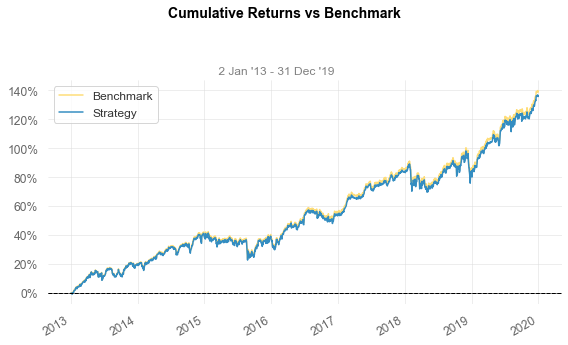

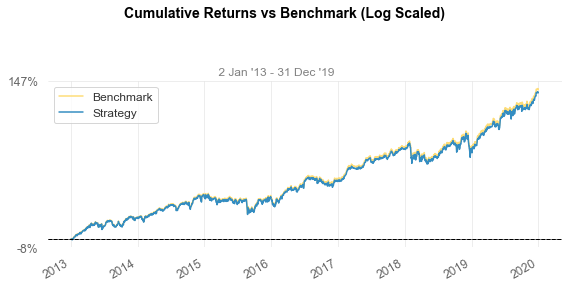

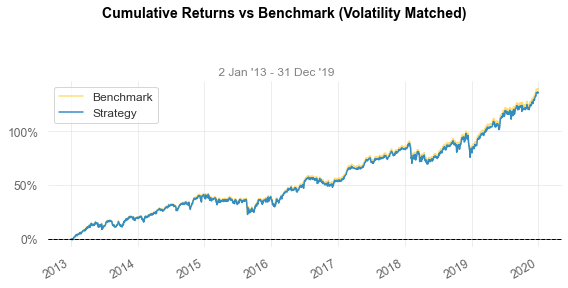

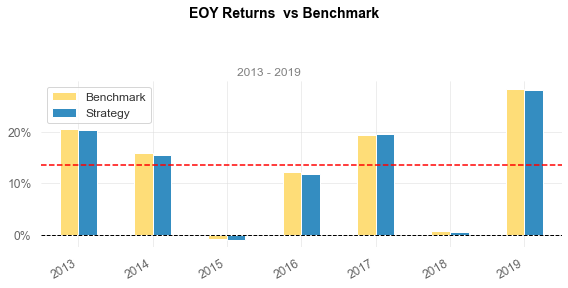

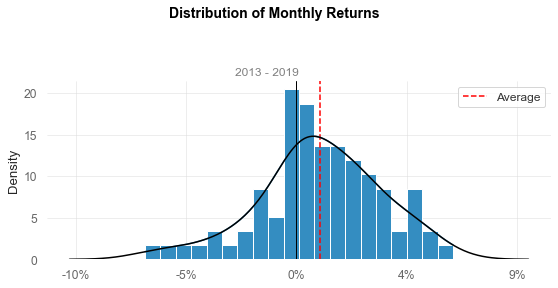

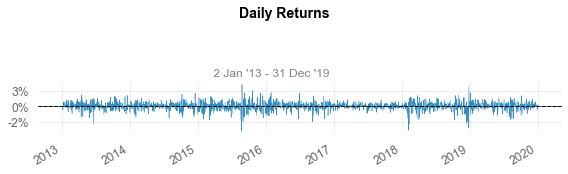

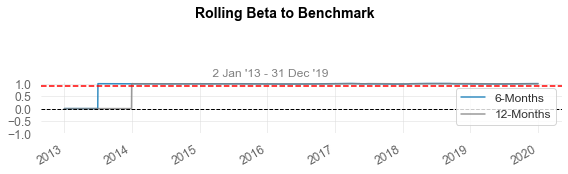

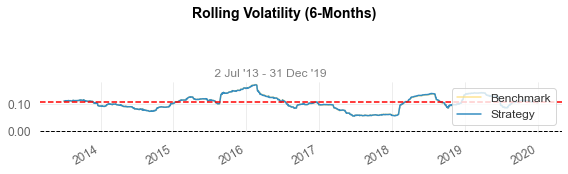

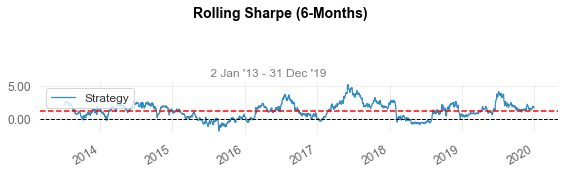

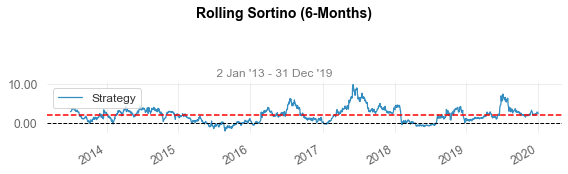

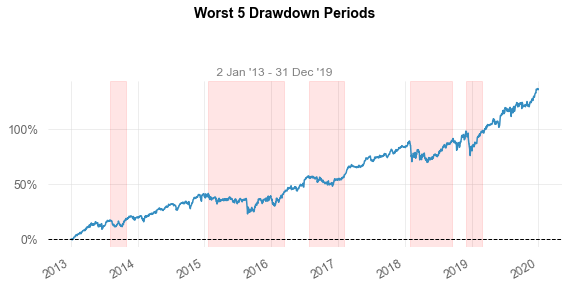

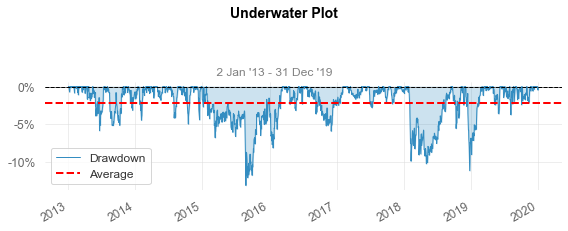

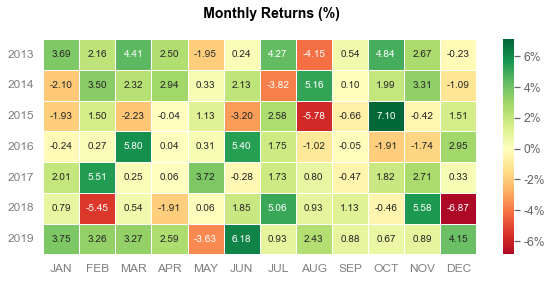

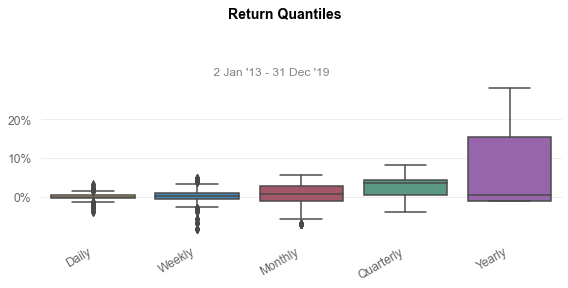

In [230]:
bnch_ret = (bt.ret * bt.w_bnch).groupby("date").sum()
bt_ret = (bt.ret * bt.w_optimal).groupby("date").sum()
qs.reports.full(bt_ret, bnch_ret)